INFO:root:Dataloader: Loaded dataset: homeeq. Returning data.
INFO:root:Finished training auxiliary classifier. ACC: 0.8883 AUC: 0.8961 BCE: 0.2902
INFO:root:Pretrained the aux classifier. Proceeding to training GAN or aux teacher if used.
INFO:root:Starting training. Expecting to train for 300 epochs at 84 iters per epoch to reach target of 25200.


[ 2500/25200] LG:0.754 LD:0.382 D:0.408 GP:0.002 AC: 0.357 RMSEAVG:0.052 NUM:0.053 SynTraiAuc:0.375 RFAcc:0.869    


INFO:root:Saving models to Experiments/results/2020-07-31_16-41_JCMQ/models. Current iter is 5000.


[ 5000/25200] LG:1.896 LD:1.189 D:1.307 GP:0.008 AC: 0.368 RMSEAVG:0.058 NUM:0.032 SynTraiAuc:0.709 RFAcc:0.759  
[ 7500/25200] LG:4.950 LD:5.305 D:5.633 GP:0.022 AC: 0.397 RMSEAVG:0.075 NUM:0.034 SynTraiAuc:0.709 RFAcc:0.789  
[10000/25200] LG:8.565 LD:10.551 D:11.459 GP:0.061 AC: 0.366 RMSEAVG:0.122 NUM:0.032 SynTraiAuc:0.701 RFAcc:0.831  


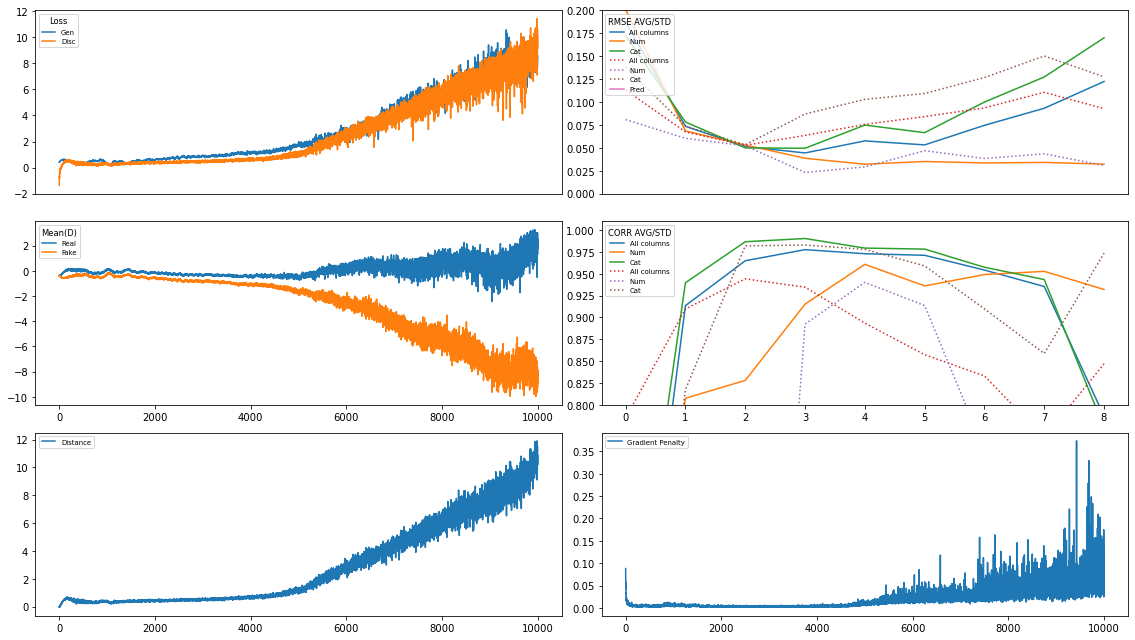

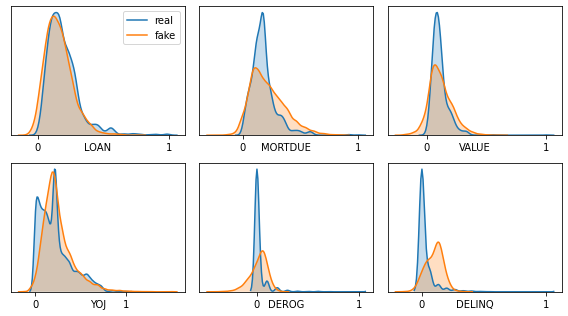

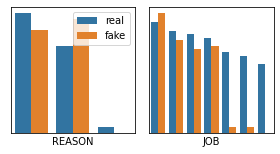

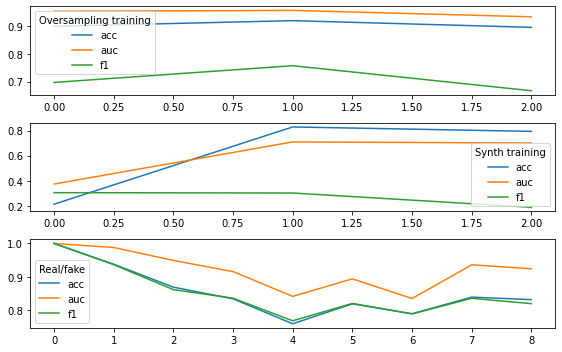

INFO:root:Saving models to Experiments/results/2020-07-31_16-41_JCMQ/models. Current iter is 10000.
INFO:root:Saving synthetic data to Experiments/results/2020-07-31_16-41_JCMQ/data. Current iter is 10000.


[12500/25200] LG:15.151 LD:7.427 D:16.353 GP:0.595 AC: 0.336 RMSEAVG:0.112 NUM:0.023 SynTraiAuc:0.701 RFAcc:0.869   


INFO:root:Saving models to Experiments/results/2020-07-31_16-41_JCMQ/models. Current iter is 15000.


[15000/25200] LG:27.955 LD:28.357 D:30.012 GP:0.110 AC: 0.303 RMSEAVG:0.152 NUM:0.054 SynTraiAuc:0.686 RFAcc:0.886  
[17500/25200] LG:38.204 LD:33.641 D:34.422 GP:0.052 AC: 0.333 RMSEAVG:0.146 NUM:0.087 SynTraiAuc:0.686 RFAcc:0.950  
[20000/25200] LG:48.172 LD:50.197 D:52.434 GP:0.149 AC: 0.306 RMSEAVG:0.155 NUM:0.088 SynTraiAuc:0.685 RFAcc:0.919  


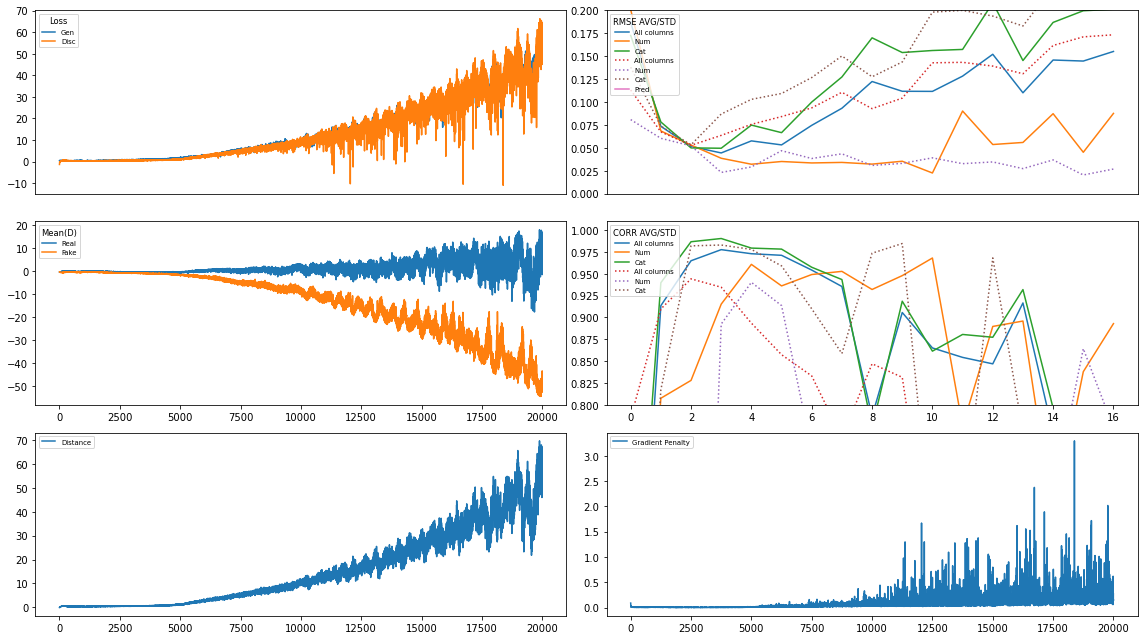

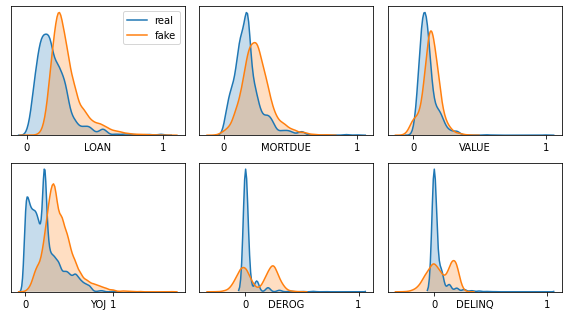

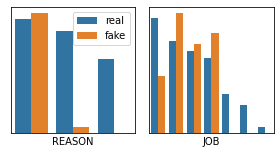

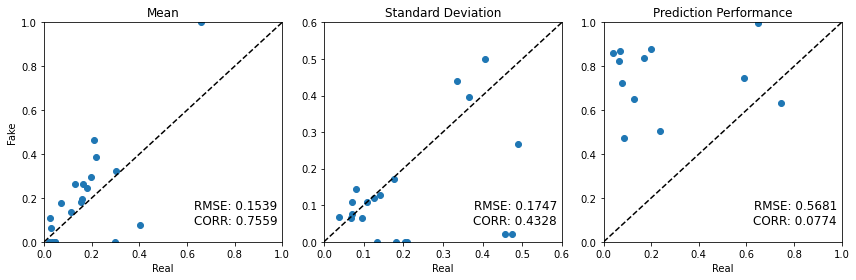

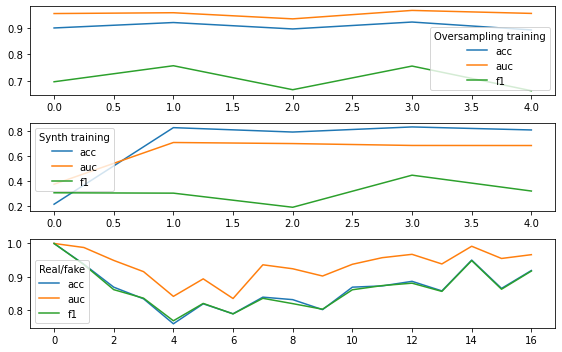

INFO:root:Saving models to Experiments/results/2020-07-31_16-41_JCMQ/models. Current iter is 20000.
INFO:root:Saving synthetic data to Experiments/results/2020-07-31_16-41_JCMQ/data. Current iter is 20000.


[22500/25200] LG:69.960 LD:54.893 D:57.638 GP:0.183 AC: 0.493 RMSEAVG:0.625 NUM:0.836 SynTraiAuc:0.685 RFAcc:1.000  


INFO:root:Saving models to Experiments/results/2020-07-31_16-41_JCMQ/models. Current iter is 25000.


[25000/25200] LG:76.824 LD:57.963 D:63.426 GP:0.364 AC: 0.332 RMSEAVG:0.633 NUM:0.864 SynTraiAuc:0.569 RFAcc:1.000  


INFO:root:Finished training after 25200/25200.
INFO:root:Saving model, data, metrics and plots.


[25200/25200] LG:80.864 LD:43.443 D:45.607 GP:0.144 AC: 0.321 RMSEAVG:0.633 NUM:0.864 SynTraiAuc:0.569 RFAcc:1.000  


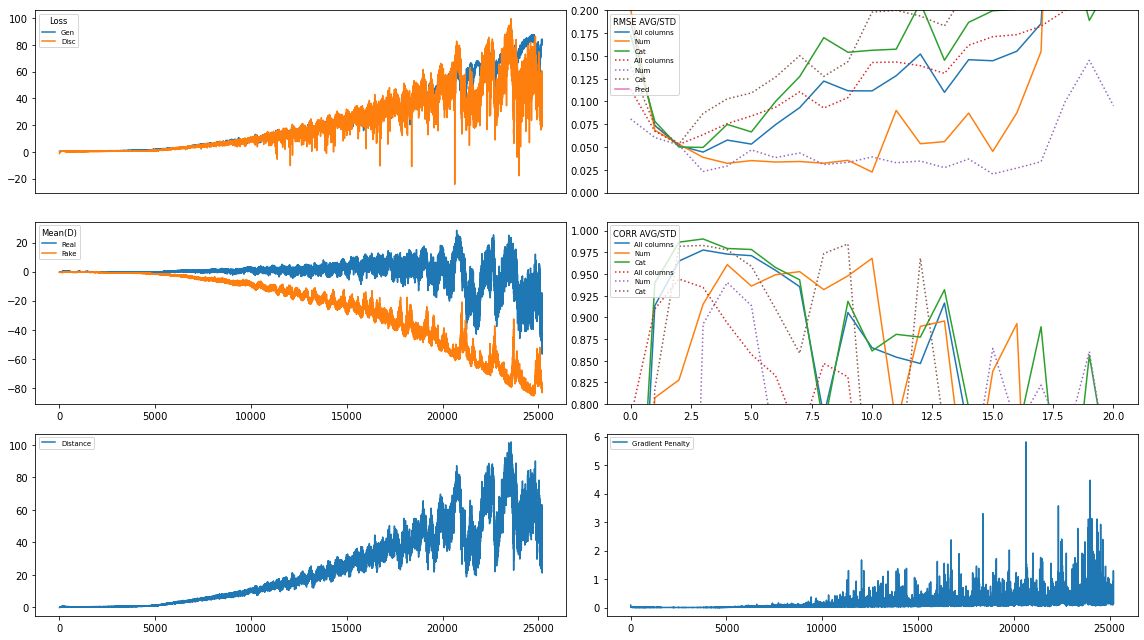

INFO:root:Saving synthetic data to Experiments/results/2020-07-31_16-41_JCMQ/data. Current iter is 25200.
INFO:root:Saving metrics to Experiments/results/2020-07-31_16-41_JCMQ/metrics. Current iter is 25200.
INFO:root:Saving models to Experiments/results/2020-07-31_16-41_JCMQ/models. Current iter is 25200.
d:\anaconda\envs\ganthesis\lib\site-packages\torch\storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


Original imbalance ratio was:0.20
After resampling it is:0.50
AUC-ROC Random Forest:
Balanced data:		0.9749
Imbalanced data:	0.9747


In [1]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

from dataloader import load_data
from helpers import get_cat_dims

from models import WGANGP

import logging
logging.getLogger().setLevel(logging.INFO)

dataset = 'homeeq' # baesens et al. Home Equity

# load data
df, cat_cols, num_cols, target_col = load_data(dataset)
X = df.loc[:, num_cols + cat_cols]
y = df.loc[:, target_col]

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=2020)
cat_dims = get_cat_dims(X_train, cat_cols)

# preprocess data
num_prep = make_pipeline(SimpleImputer(strategy='mean'),
                         MinMaxScaler())
cat_prep = make_pipeline(SimpleImputer(strategy='most_frequent'),
                         OneHotEncoder(handle_unknown='ignore', sparse=False))
prep = ColumnTransformer([
    ('num', num_prep, num_cols),
    ('cat', cat_prep, cat_cols)],
    remainder='drop')
X_train_trans = prep.fit_transform(X_train)

gan = WGANGP(write_to_disk=True, # whether to create an output folder. Plotting will be surpressed if flase
            compute_metrics_every=1250, print_every=2500, plot_every=10000,
            num_cols = num_cols, cat_dims=cat_dims,
            # pass the one hot encoder to the GAN to enable count plots of categorical variables
            transformer=prep.named_transformers_['cat']['onehotencoder'],
            # pass column names to enable
            cat_cols=cat_cols,
            use_aux_classifier_loss=True,
            d_updates_per_g=3, gp_weight=15)

gan.fit(X_train_trans, y=y_train.values, 
        condition=True,
        epochs=300,  
        batch_size=64,
        netG_kwargs = {'hidden_layer_sizes': (128,64), 
                        'n_cross_layers': 1,
                        'cat_activation': 'gumbel_softmax',
                        'num_activation': 'none',
                        'condition_num_on_cat': True, 
                        'noise_dim': 30, 
                        'normal_noise': False,
                        'activation':  'leaky_relu',
                        'reduce_cat_dim': True,
                        'use_num_hidden_layer': True,
                        'layer_norm':False,},
        netD_kwargs = {'hidden_layer_sizes': (128,64,32),
                        'n_cross_layers': 2,
                        'embedding_dims': 'auto',
                        'activation':  'leaky_relu',
                        'sigmoid_activation': False,
                        'noisy_num_cols': True,
                        'layer_norm':True,}
       )

X_res, y_res = gan.resample(X_train_trans, y=y_train)
print(f'Original imbalance ratio was:{y_train.mean():.2f}\nAfter resampling it is:{y_res.mean():.2f}')

X_test_trans = prep.transform(X_test)
clf = RandomForestClassifier(n_estimators=300, min_samples_leaf=1, max_features='sqrt', bootstrap=True,
                             random_state=2020, n_jobs=2)

clf.fit(X_res, y_res)
preds_oversampled = clf.predict_proba(X_test_trans)[:,1]

clf.fit(X_train_trans, y_train)
preds_imbalanced = clf.predict_proba(X_test_trans)[:,1]

print(f'AUC-ROC Random Forest:\n'
      f'Balanced data:\t\t{roc_auc_score(y_test, preds_oversampled):.4f}\n'
      f'Imbalanced data:\t{roc_auc_score(y_test, preds_imbalanced):.4f}')